# Algorithmic Breakdown - LGSSM

In [4]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

In [5]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple
from jax.random import multivariate_normal, split
from tqdm.notebook import tqdm, trange
from jax.random import multivariate_normal
from tensorflow_probability.substrates import jax as tfp
from jaxkf._src.functional.filter import kalman_step, filter_step_sequential, forward_filter
tfd = tfp.distributions
import jaxkf._src.lgssm as lgssm


import matplotlib.pyplot as plt

## Data

---
Like before, we can describe the dynamical system like so:

$$
\begin{aligned}
\mathbf{z}_{t+1} &= \mathbf{F}\mathbf{z}_t + \boldsymbol{\epsilon}_\mathbf{z} \\
x_t &= \mathbf{H}\mathbf{z}_t + \boldsymbol{\epsilon}_x
\end{aligned}
$$

We can manually define the terms, $\mathbf{F}$ and $\mathbf{H}$, which represent the relationship between the variables. Here they will be

$$
\begin{aligned}
\mathbf{F} &=
\begin{bmatrix}
1 & 1 \\ 0 & 1
\end{bmatrix} \\
\mathbf{H} &=
\begin{bmatrix}
1 & 0 
\end{bmatrix}
\end{aligned}
$$

Here, we assume that the state system is as follows:

$$
\begin{aligned}
\frac{\partial z^1}{\partial t} &= z^1 + z^2 \\
\frac{\partial z^2}{\partial t} &= z^1
\end{aligned}
$$

and we assume that the observation is related like so:

$$
x = z^1
$$

So essentially, we have an augmented the state space dimension, $\mathbf{z} \in \mathbb{R}^2$, which is higher than the observation space, $x \in \mathbb{R}^1$. Our assumption here is that there are higher order dynamics at play behind the scenes. 


#### Parameters

$$
\boldsymbol{\theta} = \{ \mathbf{F}, \mathbf{Q}, \mathbf{H}, \mathbf{R} \}
$$

## Parameters

#### LGSSM Params

In [6]:
class KFParams(NamedTuple):
    transition_matrix : jnp.ndarray
    transition_noise : jnp.ndarray
    observation_matrix : jnp.ndarray
    observation_noise : jnp.ndarray
    
class KFParamsDist(NamedTuple):
    transition_matrix: jnp.ndarray
    transition_noise_dist: tfd.Distribution
    observation_matrix: jnp.ndarray
    observation_noise_dist: tfd.Distribution


In [1037]:
# initialize Kalman Filter
state_dim = 2
observation_dim = 1

# init transition model
transition_matrix = jnp.array([[1., 1.], [0., 1.]])   # state transition matrix
transition_noise = 1e-4 * jnp.eye((state_dim))                # state uncertainty

# check sizes
assert transition_matrix.shape == (state_dim, state_dim)
assert transition_noise.shape == (state_dim, state_dim)

# init emission model
observation_matrix = jnp.array([[1., 0.]])             # emission matrix
observation_noise = 1e-3 * jnp.eye((1))                  # emission uncertainty

assert observation_matrix.shape == (observation_dim, state_dim)
assert observation_noise.shape == (observation_dim, observation_dim)


# Prior parameter distribution
mu0 = jnp.array([2.0, 0.0]).astype(float)
Sigma0 = jnp.eye(state_dim) * 1.0

assert mu0.shape == (state_dim,)
assert Sigma0.shape == (state_dim, state_dim)

In [1038]:
observation_matrix.T.shape

(2, 1)

In [1039]:

transition_noise_dist = tfd.MultivariateNormalDiag(
    loc=jnp.zeros(state_dim), 
    scale_diag=jnp.diag(transition_noise)
)


observation_noise_dist = tfd.MultivariateNormalDiag(
    loc=jnp.zeros(observation_dim), 
    scale_diag=jnp.diag(observation_noise)
)


params_dist = KFParamsDist(
    transition_matrix=transition_matrix, 
    transition_noise_dist=transition_noise_dist,
    observation_matrix=observation_matrix, 
    observation_noise_dist=observation_noise_dist
)

params = KFParams(
    transition_matrix=transition_matrix, 
    transition_noise=transition_noise,
    observation_matrix=observation_matrix, 
    observation_noise=observation_noise
)

#### KF State

In [1040]:
class State(NamedTuple):
    mu_t: jnp.ndarray
    Sigma_t: jnp.ndarray
    t: int
    
class StatePrior(NamedTuple):
    prior: tfd.Distribution
    

In [1041]:
prior_dist = tfd.MultivariateNormalFullCovariance(
    loc=mu0, 
    covariance_matrix=Sigma0
)

state_prior = StatePrior(prior=prior_dist)

In [1042]:
prior_dist.covariance().shape, prior_dist.mean().shape

((2, 2), (2,))

## Demo States

In [1043]:
from jaxkf._src.functional.sample import sample_step, sample_sequential, sample_sequential_vectorized, sample_event

In [1044]:
# init keys - prior, steps
key = jax.random.PRNGKey(411)
key, key_init, key_step = jax.random.split(key, 3)

# initialize state mean
state_init = state_prior.prior.sample(seed=key_init)

assert state_init.shape == (state_dim,)

#### Vectorized Sampling

In [1045]:
%%time

num_samples = 100
num_time_steps = 50
key = 314
sample_prior = False

state_samples, obs_samples = sample_sequential_vectorized(
    prior_dist, 
    params_dist, 
    seed=key, 
    num_samples=num_samples, 
    num_time_steps=num_time_steps,
    sample_prior=sample_prior
)

CPU times: user 1.11 s, sys: 14.3 ms, total: 1.13 s
Wall time: 1.12 s


In [1046]:
# check shapes
assert state_samples.shape == (num_samples, num_time_steps, state_dim)
assert obs_samples.shape == (num_samples, num_time_steps, observation_dim)

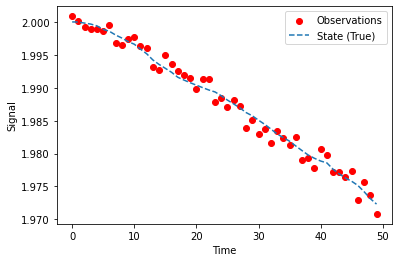

In [1048]:
fig, ax = plt.subplots()

ts = jnp.arange(num_time_steps)
batch_idx = 10
ax.scatter(ts, obs_samples[batch_idx, ..., 0], color="red", label="Observations")
ax.plot(ts, state_samples[batch_idx, ..., 0], label="State (True)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

## Training (Optax)

In [1049]:
import treex as tx
from jax.nn import softplus

In [1050]:
class LGSSM(tx.Module):
    # define free and fixed params
    # transition_matrix: jnp.ndarray = tx.Parameter.node()
    # transition_noise: jnp.ndarray = tx.Parameter.node()
    emission_matrix: jnp.ndarray = tx.Parameter.node()
    emission_noise: jnp.ndarray = tx.Parameter.node()
    prior_mean: jnp.ndarray = tx.Parameter.node()
    prior_cov: jnp.ndarray = tx.Parameter.node()
    
    def __init__(self, prior_mean, prior_cov, kf_params):
        print('err')
        # init prior
        self.prior_mean = prior_mean
        self.prior_cov = prior_cov
        
        # init parameters
        self.transition_matrix = kf_params.transition_matrix
        self.transition_noise = kf_params.transition_noise
        self.emission_matrix = kf_params.observation_matrix
        self.emission_noise = kf_params.observation_noise
    
    def __call__(self, x):
        """Do filtering operation"""
        
        prior_dist = tfd.MultivariateNormalFullCovariance(
            loc=self.prior_mean, 
            scale_diag=jnp.diag(self.prior_cov)
        )

        state_prior = StatePrior(prior=prior_dist)
        
        # noise dist
        trans_noise = self.transition_noise
        trans_noise = softplus(trans_noise)
        trans_noise = jnp.diag(trans_noise)
        
        emis_noise = self.emission_noise
        emis_noise = softplus(emis_noise)
        emis_noise = jnp.diag(emis_noise)
        
      # create noise dists
        transition_noise_dist = tfd.MultivariateNormalDiag(
            loc=jnp.zeros(2), 
            scale_diag=trans_noise
        )


        observation_noise_dist = tfd.MultivariateNormalDiag(
            loc=jnp.zeros(1), 
            scale_diag=emis_noise
        )
        
        
        kf_params = KFParams(
            transition_matrix=self.transition_matrix,
            transition_noise=trans_noise,
            observation_matrix=self.emission_matrix,
            observation_noise=emis_noise
        )
        
        print('hey;')
        
        state = forward_filter(x, state_prior, kf_params)
        
        mus, sigmas, log_likelihoods, *_ = state
        
        return mus, sigmas, log_likelihoods
    
#     def filter_forward(self, obs):
        
#         # create new params
#         state = forward_filter(obs_samples, state_prior, params)
    
#         mus, sigmas, log_likelihoods, *_ = state
        
#         return mus, sigmas
    
#     def log_prob(self, obs):
        
#         state = self.__filter_forward(obs)
        
#         mus, sigmas, log_likelihoods, *_ = state
        
#         return log_likelihoods
    
    
#     def __filter_forward(self, obs):
        
#         prior_dist = tfd.MultivariateNormalFullCovariance(
#             loc=self.prior_mean, 
#             covariance_matrix=self.prior_cov
#         )

#         state_prior = StatePrior(prior=prior_dist)
        
#         params = KFParams(
#             transition_matrix=self.transition_matrix,
#             transition_noise=self.transition_noise,
#             observation_matrix=self.emission_matrix,
#             observation_noise=self.emission_noise
#         )
        
        
#         return 


class KalmanFilter(LGSSM):
    # define free and fixed params
    # transition_matrix: jnp.ndarray = tx.State.node()
    transition_noise: jnp.ndarray = tx.Parameter.node()
    # emission_matrix: jnp.ndarray = tx.State.node()
    emission_noise: jnp.ndarray = tx.Parameter.node()
    # prior_mean: tx.State.node()
    # prior_cov: tx.State.node()
    def __call__(self, x):
        """Do filtering operation"""
        print("ere")
        
        prior_dist = tfd.MultivariateNormalFullCovariance(
            loc=self.prior_mean, 
            covariance_matrix=self.prior_cov
        )

        state_prior = StatePrior(prior=prior_dist)
        
        # noise dist
        trans_noise = self.transition_noise
        trans_noise = softplus(trans_noise)
        trans_noise = jnp.diag(trans_noise ** 2)
        
        emis_noise = self.emission_noise
        emis_noise = softplus(emis_noise)
        emis_noise = jnp.diag(emis_noise ** 2)
        
        # create noise dists
        transition_noise_dist = tfd.MultivariateNormalFullCovariance(
            loc=jnp.zeros(2), 
            covariance_matrix=trans_noise
        )


        observation_noise_dist = tfd.MultivariateNormalFullCovariance(
            loc=jnp.zeros(1), 
            covariance_matrix=emis_noise
        )
        
        
        kf_params = KFParams(
            transition_matrix=self.transition_matrix,
            transition_noise=transition_noise_dist.covariance(),
            observation_matrix=self.emission_matrix,
            observation_noise=observation_noise_dist.covariance()
        )
        
        state = forward_filter(x, state_prior, kf_params)
        
        mus, sigmas, log_likelihoods, *_ = state
        
        return mus, sigmas, log_likelihoods
    

In [1051]:
class LGSSM(tx.Module):
    # define free and fixed params
    transition_matrix: jnp.ndarray = tx.Parameter.node()
    transition_noise: jnp.ndarray = tx.Parameter.node()
    emission_matrix: jnp.ndarray = tx.Parameter.node()
    emission_noise: jnp.ndarray = tx.Parameter.node()
    prior_mean: jnp.ndarray = tx.Parameter.node()
    prior_cov: jnp.ndarray = tx.Parameter.node()
    
    def __init__(self, prior_mean, prior_cov, kf_params):
        # init prior
        self.prior_mean = prior_mean
        self.prior_cov = prior_cov
        
        # init parameters
        self.transition_matrix = kf_params.transition_matrix
        self.transition_noise = kf_params.transition_noise
        self.emission_matrix = kf_params.observation_matrix
        self.emission_noise = kf_params.observation_noise
    
    def __call__(self, x):
        """Do filtering operation"""
        
        prior_dist = tfd.MultivariateNormalDiag(
            loc=self.prior_mean, 
            scale_diag=self.prior_cov
        )

        state_prior = StatePrior(prior=prior_dist)
        
        # noise dist
        trans_noise = self.transition_noise
        trans_noise = softplus(trans_noise)
        
        emis_noise = self.emission_noise
        emis_noise = softplus(emis_noise)
        
      # create noise dists
        transition_noise_dist = tfd.MultivariateNormalDiag(
            loc=jnp.zeros(2), 
            scale_diag=trans_noise
        )


        observation_noise_dist = tfd.MultivariateNormalDiag(
            loc=jnp.zeros(1), 
            scale_diag=emis_noise
        )
        
        
        kf_params = KFParams(
            transition_matrix=self.transition_matrix,
            transition_noise=trans_noise,
            observation_matrix=self.emission_matrix,
            observation_noise=emis_noise
        )
                
        state = forward_filter(x, state_prior, kf_params)
        
        mus, sigmas, log_likelihoods, *_ = state
        
        return mus, sigmas, log_likelihoods
    

In [1075]:
# random params
params_rand = KFParams(
    transition_matrix=jnp.ones((2, 2)),
    transition_noise=1.0 * jnp.ones((2)),
    observation_matrix=jnp.ones((1, 2)),
    observation_noise=1.0 * jnp.ones((1)),
)

prior_mean = jnp.zeros((2,))
prior_cov = jnp.zeros((2,))
state_prior = StatePrior(prior=prior_dist)


# params = KFParams(
#     transition_matrix=transition_matrix, 
#     transition_noise=10.0 * jnp.ones((state_dim)),
#     observation_matrix=observation_matrix, 
#     observation_noise=10.0 * jnp.ones((observation_dim))
# )

# initialize model
kf_model = LGSSM(prior_mean=prior_mean, prior_cov=prior_cov, kf_params=params_rand).init(key=123)
# kf_model = KalmanFilter(state_prior=state_prior, kf_params=params).init(key=123)


In [1115]:
class KalmanFilter(tx.Module):
    # define free and fixed params
    # transition_matrix: jnp.ndarray = tx.Parameter.node()
    transition_noise: jnp.ndarray = tx.Parameter.node()
    # emission_matrix: jnp.ndarray = tx.Parameter.node()
    emission_noise: jnp.ndarray = tx.Parameter.node()
    prior_mean: jnp.ndarray = tx.Parameter.node()
    prior_cov: jnp.ndarray = tx.Parameter.node()
    
    def __init__(self, prior_mean, prior_cov, kf_params):
        # init prior
        self.prior_mean = prior_mean
        self.prior_cov = prior_cov
        
        # init parameters
        self.transition_matrix = kf_params.transition_matrix
        self.transition_noise = kf_params.transition_noise
        self.emission_matrix = kf_params.observation_matrix
        self.emission_noise = kf_params.observation_noise
    
    def __call__(self, x):
        """Do filtering operation"""
        
        prior_dist = tfd.MultivariateNormalDiag(
            loc=self.prior_mean, 
            scale_diag=self.prior_cov
        )

        state_prior = StatePrior(prior=prior_dist)
        
        # noise dist
        trans_noise = self.transition_noise
        trans_noise = softplus(trans_noise)
        
        emis_noise = self.emission_noise
        emis_noise = softplus(emis_noise)
        
      # create noise dists
        transition_noise_dist = tfd.MultivariateNormalDiag(
            loc=jnp.zeros(2), 
            scale_diag=trans_noise
        )


        observation_noise_dist = tfd.MultivariateNormalDiag(
            loc=jnp.zeros(1), 
            scale_diag=emis_noise
        )
        
        
        kf_params = KFParams(
            transition_matrix=self.transition_matrix,
            transition_noise=trans_noise,
            observation_matrix=self.emission_matrix,
            observation_noise=emis_noise
        )
                
        state = forward_filter(x, state_prior, kf_params)
        
        mus, sigmas, log_likelihoods, *_ = state
        
        return mus, sigmas, log_likelihoods

In [1116]:
# random params
params_rand = KFParams(
    transition_matrix=transition_matrix,
    transition_noise=1.0 * jnp.ones((2)),
    observation_matrix=observation_matrix,
    observation_noise=1.0 * jnp.ones((1)),
)

prior_mean = jnp.zeros((2,))
prior_cov = jnp.ones((2,))
state_prior = StatePrior(prior=prior_dist)


# params = KFParams(
#     transition_matrix=transition_matrix, 
#     transition_noise=10.0 * jnp.ones((state_dim)),
#     observation_matrix=observation_matrix, 
#     observation_noise=10.0 * jnp.ones((observation_dim))
# )

# initialize model
kf_model = KalmanFilter(prior_mean=prior_mean, prior_cov=prior_cov, kf_params=params_rand).init(key=123)
# kf_model = KalmanFilter(state_prior=state_prior, kf_params=params).init(key=123)





In [1117]:
kf_params = kf_model.parameters()

In [1118]:
kf_params.emission_noise, kf_params.transition_noise

(DeviceArray([1.], dtype=float32), DeviceArray([1., 1.], dtype=float32))

### Loss

In [1119]:
# differentiate only w.r.t. parameters
def loss_fn(params, model, x):
    # merge params into model
    model = model.merge(params)

    # forward transformation
    *_, log_prob = model(x)
    
    log_prob = log_prob.sum(axis=1)
    
    # calculate nll
    loss = - jnp.mean(log_prob)

    # the model may contain state updates
    # so it should be returned
    return loss, model

In [1120]:
model_params = kf_model.parameters()

loss, kf_model_ = loss_fn(model_params, kf_model, obs_samples)
loss

DeviceArray(89.55986, dtype=float32)

#### Train Step

In [1121]:
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

In [1122]:
(loss_, m_), grads_ = grad_fn(model_params, kf_model, obs_samples)

In [1123]:
m_

KalmanFilter {
    emission_matrix: jaxlib.DeviceArray((1, 2), float32),      DeviceArray
    emission_noise: jaxlib.DeviceArray((1,), float32),         Parameter
    name: "kalman_filter",                                     str
    prior_cov: jaxlib.DeviceArray((2,), float32),              Parameter
    prior_mean: jaxlib.DeviceArray((2,), float32),             Parameter
    transition_matrix: jaxlib.DeviceArray((2, 2), float32),    DeviceArray
    transition_noise: jaxlib.DeviceArray((2,), float32),       Parameter
}

In [1124]:
loss_

DeviceArray(89.55986, dtype=float32)

In [1125]:
# both model and optimizer are jit-able
@jax.jit
def train_step(model, x, optimizer):
    # select only the parameters
    params = model.parameters()

    (loss, model), grads = grad_fn(params, model, x)

    # update params and model
    params = optimizer.update(grads, params)
    model = model.merge(params)

    # return new model and optimizer
    return loss, model, optimizer

### Optimizer

In [1126]:
import optax
from tqdm.notebook import trange, tqdm

In [1127]:
optimizer = tx.Optimizer(optax.adam(0.1)).init(kf_model)

In [1128]:
n_iterations = 200
losses = []
batch_size = 64

train_data = obs_samples

with trange(n_iterations) as pbar:
    for i in pbar:
        
        loss, kf_model, optimizer = train_step(kf_model, train_data, optimizer)
        
        if i % 100 == 0:
            pbar.set_description(f"Loss: {loss:.4f}")
        losses.append(loss)

  0%|          | 0/200 [00:00<?, ?it/s]

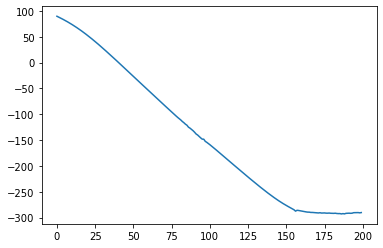

In [1129]:
fig, ax = plt.subplots()

ax.plot(losses)

plt.show()

In [1130]:
trained_params = kf_model.parameters()

In [1131]:
trained_params.emission_noise, trained_params.transition_noise

(DeviceArray([-16.013824], dtype=float32),
 DeviceArray([-17.712055, -16.23422 ], dtype=float32))

In [1132]:
softplus(trained_params.transition_noise), softplus(trained_params.emission_noise)

(DeviceArray([2.0311976e-08, 8.9036398e-08], dtype=float32),
 DeviceArray([1.10990136e-07], dtype=float32))

In [1133]:
mus, sigmas, log_probs = kf_model(obs_samples)

In [1134]:
obs_samples.shape, mus.shape

((100, 50, 1), (100, 50, 2))

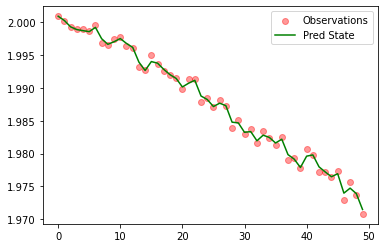

In [1135]:
fig, ax = plt.subplots()

t_axes = jnp.arange(num_time_steps)

batch_idx = 10

ax.scatter(t_axes, obs_samples[batch_idx, :, 0], label="Observations", color="red", alpha=0.4)
ax.plot(t_axes, mus[batch_idx, :, 0], label="Pred State", color="green")

plt.legend()
plt.show()

In [ ]:
# initialize Kalman Filter
state_dim = 2
observation_dim = 1

# init transition model
transition_matrix = jnp.array([[1., 1.], [0., 1.]])   # state transition matrix
transition_noise = 1e-4 * jnp.eye((state_dim))                # state uncertainty

# check sizes
assert transition_matrix.shape == (state_dim, state_dim)
assert transition_noise.shape == (state_dim, state_dim)

# init emission model
observation_matrix = jnp.array([[1., 0.]])             # emission matrix
observation_noise = 50. * jnp.eye((1))                  # emission uncertainty

assert observation_matrix.shape == (observation_dim, state_dim)
assert observation_noise.shape == (observation_dim, observation_dim)


# Prior parameter distribution
mu0 = jnp.array([2.0, 0.0]).astype(float)
Sigma0 = jnp.eye(state_dim) * 1.0

assert mu0.shape == (state_dim,)
assert Sigma0.shape == (state_dim, state_dim)

##

In [258]:


# initia
transition_noise_dist = lgssm.MultivariateNormal(jnp.zeros(state_dim), transition_noise)

observation_noise_dist = lgssm.MultivariateNormal(jnp.zeros(observation_dim), observation_noise)

initial_state_prior_dist = lgssm.MultivariateNormal(mu0, Sigma0)

kf_model = lgssm.LinearGaussianStateSpaceModel(
    transition_matrix, transition_noise_dist,
    observation_matrix, observation_noise_dist,
    initial_state_prior_dist
)

In [259]:
%%time

log_probs, mus, sigmas, mus_cond, sigmas_cond = kf_model.forward_filter(obs_samples[0])


mus.shape, sigmas.shape

CPU times: user 361 ms, sys: 6.23 ms, total: 367 ms
Wall time: 365 ms


((50, 2), (50, 2, 2))

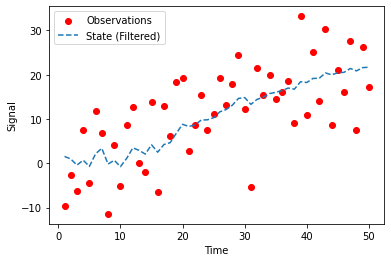

In [261]:
fig, ax = plt.subplots()


ax.scatter(ts[0], obs_samples[0], color="red", label="Observations")
ax.plot(ts[0], mus[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

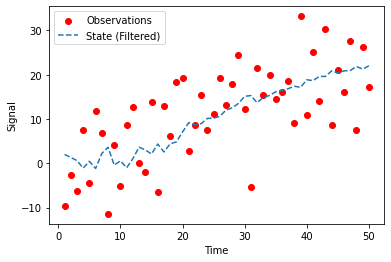

In [263]:
fig, ax = plt.subplots()


ax.scatter(ts[0], obs_samples[0], color="red", label="Observations")
ax.plot(ts[0], mus_cond[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

In [19]:
state.shape, obs.shape

((2,), (1,))

In [20]:
# initialize states
all_states, all_obs = [], []

state = state_init

for i_step in tqdm(sample_keys):
    
    # kalman step
    state, (state, obs) = kf_model.sample_step(state, i_step)
    
    # append
    all_states.append(state)
    all_obs.append(obs)
    

all_states = jnp.vstack(all_states)
all_obs = jnp.vstack(all_obs)

NameError: name 'sample_keys' is not defined

TypeError: list indices must be integers or slices, not tuple

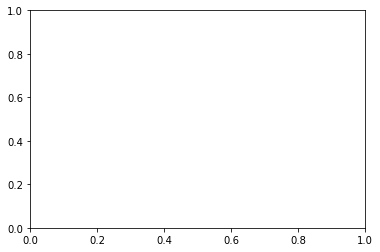

In [21]:
fig, ax = plt.subplots()

ax.plot(time_steps, all_states[:, 0], label="True State", color="green")
ax.scatter(time_steps, all_obs, label="Observations", color="red", alpha=0.4)

plt.legend()
plt.show()

In [112]:
num_time_steps = 100

all_states, all_obs = kf_model.sample(seed=123, sample_shape=10, num_timesteps=num_time_steps)
states.shape, all_obs.shape

((1, 100, 2), (10, 100, 1))

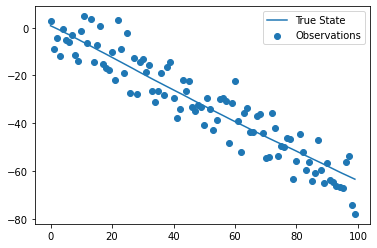

In [117]:
fig, ax = plt.subplots()

ax.plot(time_steps, all_states[3, :, 0], label="True State")
ax.scatter(time_steps, all_obs[3, :, 0], label="Observations")

plt.legend()
plt.show()

In [100]:
mu0.shape

(2,)

In [130]:
kf_model.sample_step(mu0, key)

(2,) (2, 1) (1,)


TypeError: dot_general requires contracting dimensions to have the same shape, got [1] and [2].

---

## Filtering

1. Do Forward Filter for a batch of inputs
2. Init prior mean, cov
3. Loop Through Kalman Step (mu0, cov0)

In [11]:
from jaxkf._src.functional.ops import kalman_step

In [14]:
num_time_steps = 15

states_preds, states_corrs = [], []

for i_t_step in trange(num_time_steps):
    
    # kalman step
    state_pred, state_corrected = kalman_step(
    
    pass

SyntaxError: invalid syntax (2776370347.py, line 12)

### Kalman Filter Step

### Predict Step

## Smoothing

### Posterior Marginals (Alternative)

## Log Probability

## Model

##### Initialize Parameters

In [12]:
kf_params = KFParams(
    F=F, R=R,
    H=H, Q=Q
)

## State

In [13]:
class State(NamedTuple):
    mu_t: jnp.ndarray
    Sigma_t: jnp.ndarray
    t: int

In [14]:
# init state
init_mean = jnp.array([2., 0.])
init_cov = jnp.eye(init_mean.shape[0])

assert init_mean.shape == (state_dim,)
assert init_cov.shape == (state_dim, state_dim)

##### Initialize

In [16]:
init_state = State(
    mu_t=init_mean,
    Sigma_t=init_cov,
    t=0
)

## Sampling



1. Sample from the initial state

$$
\mathbf{x_0} \sim \mathcal{N}(\boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0; \text{key})
$$


In [24]:
key = jax.random.PRNGKey(314)


# sample from initial state
x0_key, key = split(key, 2)

state_t = multivariate_normal(key=x0_key, mean=init_mean, cov=init_cov)


In [ ]:
def sample_step(key, state, params, n_samples=1):
    
    xt_key, trans_key, obs_key = split(key, 3)
    
    # unroll state
    mu_t = init_state.mu_t
    sigma_t = init_state.Sigma_t
    
    # unroll params
    F = params.F
    R = params.R
    H = params.H
    Q = params.Q
    
    
    state_t = multivariate_normal(key=x0_key, mean=mu_t, cov=Sigma_0)
    
    # new state
    
    
    return key

In [25]:
def sample(key, init_state, params, n_samples=1):
    """Sample states"""
    , key = split(key, 2)
    
    mu_0 = init_state.mu_t
    Sigma_0 = init_state.Sigma_t
    t = init_state.t
    
    state_t = multivariate_normal(key=x0_key, mean=mu_0, cov=Sigma_0)
    
    
    pass

In [27]:
sample(key, init_state, kf_params)

## Code Layout



```python
class KFDist:
    def __init__(self):
        """Initialize the parameters"""
        pass
    
    def filter_states(self, obs):
        """Perform the filtering operation
        p(x_{1:T}|y_{1:T})
        """
        return None
    
    def log_prob(self, obs):
        """p(x_"""
        return None
    
    def rsample(self, n_samples):
        return None
    
```

### State

### Parameters

### Filter Function

In [ ]:
# mu_t, sigma_t, x_t

# get matrices
A = 

In [ ]:
def kalman_step(mu_t, sigma_t, x_t)

### Sample Function

### Training

In [ ]:
import numpyro
import numpyro.distributions

In [ ]:
def kf_model(obs):
    
    R = numpyro.sample("R", dist